In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# import necessary libraries
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import joblib
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline

# set up logging to disable TensorFlow logs
import logging
logging.getLogger('tensorflow').disabled = True

# set random seed for reproducibility
from numpy.random import seed
from tensorflow import random
seed(10)
random.set_seed(10)

# import necessary Keras libraries
from keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector
from keras.models import Model
from keras import regularizers


# Data uploading

In [ ]:
# import pandas library to read CSV files
import pandas as pd

# read CSV file from a specific file path and store the data as a DataFrame object named `df`
df = pd.read_csv('/content/drive/MyDrive/Machine_learning/PROJECTS/anomaly_detection/working_motor.csv')


In [ ]:
# print information about the DataFrame object `df`
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11792 entries, 0 to 11791
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   acclr(x)  11792 non-null  float64
 1   acclr(y)  11792 non-null  float64
 2   acclr(z)  11792 non-null  float64
 3   gyro(x)   11792 non-null  float64
 4   gyro(y)   11792 non-null  float64
 5   gyro(z)   11792 non-null  float64
dtypes: float64(6)
memory usage: 552.9 KB


In [ ]:
df.columns

Index(['acclr(x)', 'acclr(y)', 'acclr(z)', 'gyro(x)', 'gyro(y)', 'gyro(z)'], dtype='object')

In [ ]:
# print the dimensions of the DataFrame object `df`
print(df.shape)


(11792, 6)


In [ ]:
# print the first few rows of the DataFrame object `df`
print(df.head())


   acclr(x)  acclr(y)  acclr(z)  gyro(x)  gyro(y)  gyro(z)
0      0.74     -0.09      7.69    -0.06     0.00    -0.04
1      0.65     -0.14      8.45    -0.09    -0.06    -0.04
2      0.29     -0.06     10.02    -0.09    -0.08    -0.04
3      0.14     -0.07     11.03    -0.05    -0.02    -0.04
4      0.30     -0.03     10.66    -0.02     0.04    -0.04


In [ ]:
# count the number of missing values in each column of the DataFrame object `df`
print(df.isnull().sum())


acclr(x)    0
acclr(y)    0
acclr(z)    0
gyro(x)     0
gyro(y)     0
gyro(z)     0
dtype: int64


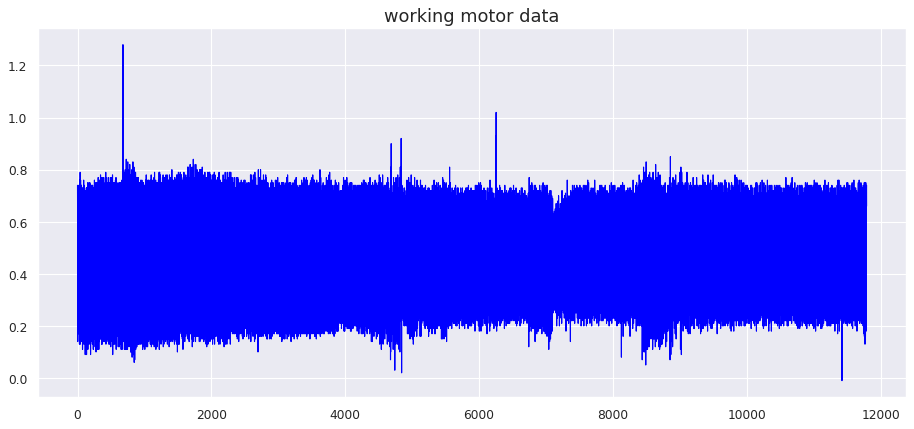

In [ ]:
# create a figure and axis object with a specified size and resolution
fig, ax = plt.subplots(figsize=(14,6), dpi=80)

# plot the 'acclr(x)' column as a blue line with a label and linewidth
ax.plot(df['acclr(x)'], label='acceleration x', color='blue', animated=True, linewidth=1)

# set the title of the plot and font size
ax.set_title('working motor data', fontsize=16)

# display the plot
plt.show()


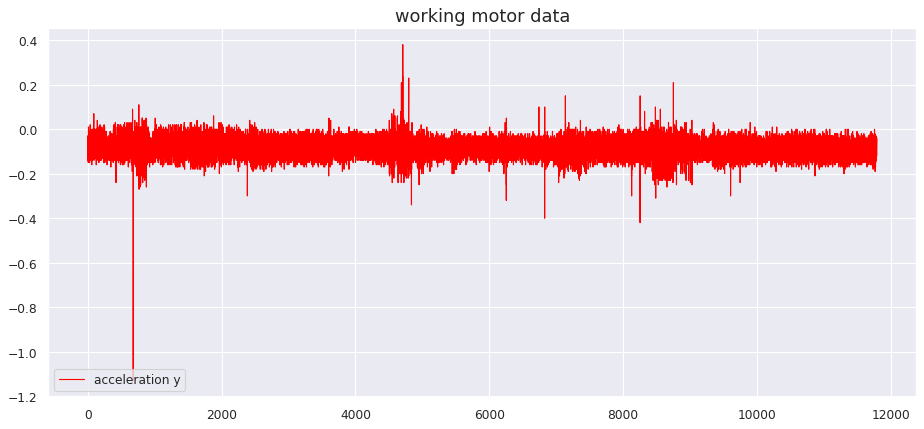

In [ ]:
fig, ax = plt.subplots(figsize = (14,6), dpi = 80)
ax.plot(df['acclr(y)'], label = 'acceleration y',color = 'red', animated = True, linewidth = 1)
ax.set_title('working motor data', fontsize = 16)
plt.legend(loc = "lower left")

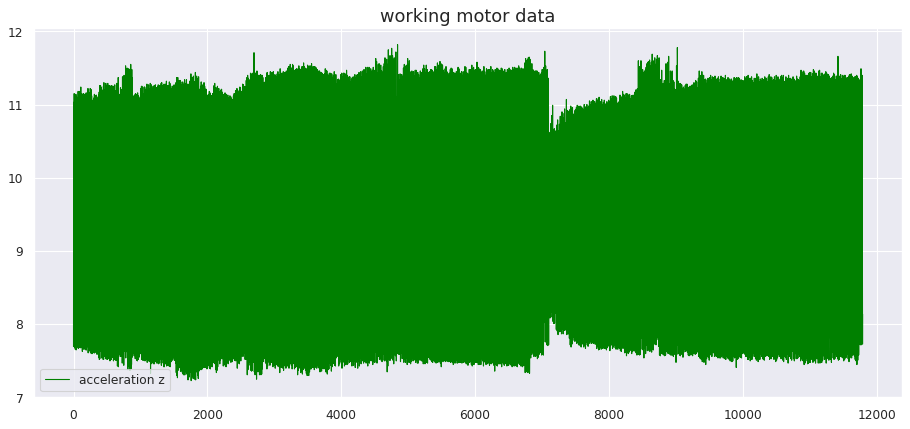

In [ ]:
fig, ax = plt.subplots(figsize = (14,6), dpi = 80)
ax.plot(df['acclr(z)'], label = 'acceleration z',color = 'green', animated = True, linewidth = 1)
ax.set_title('working motor data', fontsize = 16)
plt.legend(loc = "lower left")

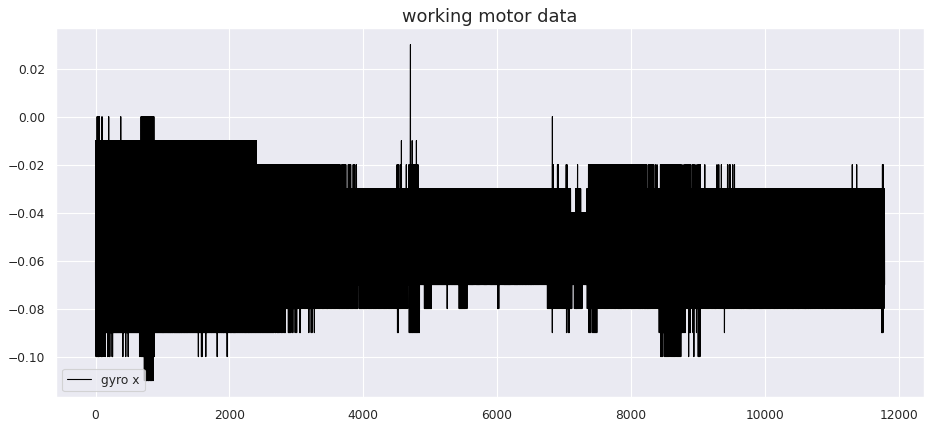

In [ ]:
fig, ax = plt.subplots(figsize = (14,6), dpi = 80)
ax.plot(df['gyro(x)'], label = 'gyro x',color = 'black', animated = True, linewidth = 1)

ax.set_title('working motor data', fontsize = 16)
plt.legend(loc = "lower left")

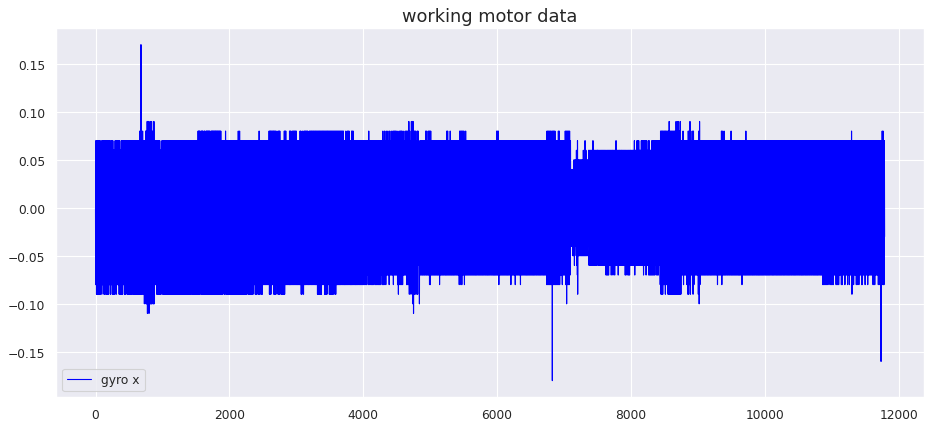

In [ ]:
fig, ax = plt.subplots(figsize = (14,6), dpi = 80)
ax.plot(df['gyro(y)'], label = 'gyro x',color = 'blue', animated = True, linewidth = 1)

ax.set_title('working motor data', fontsize = 16)
plt.legend(loc = "lower left")

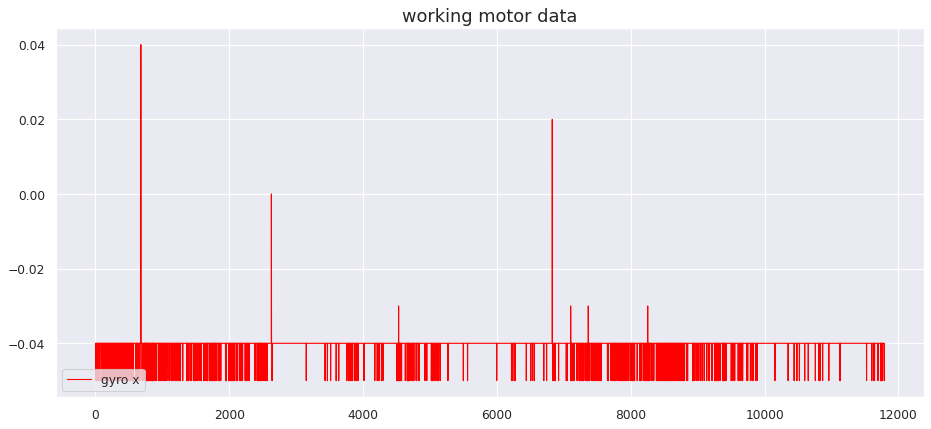

In [ ]:
fig, ax = plt.subplots(figsize = (14,6), dpi = 80)
ax.plot(df['gyro(z)'], label = 'gyro x',color = 'red', animated = True, linewidth = 1)
ax.set_title('working motor data', fontsize = 16)
plt.legend(loc = "lower left")

In [ ]:
# calculate the size of the training set as 80% of the total data size
train_size = int(len(df) * 0.8)

# calculate the size of the test set as the remaining 20%
test_size = len(df) - train_size

# split the data into training and test sets using integer indexing
train = df.iloc[0:train_size]
test = df.iloc[train_size:]


In [ ]:
# print the shape of the train and test DataFrames
print(train.shape, test.shape)


(9433, 6) (2359, 6)


In [ ]:
# transforming data from the time domain to the frequency domain using fast Fourier transform
train_fft = np.fft.fft(train)
test_fft = np.fft.fft(test)

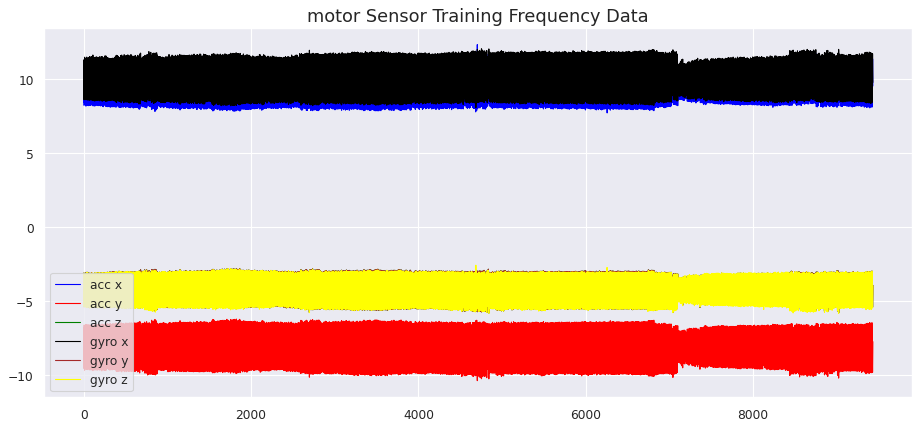

In [ ]:
# frequencies of the healthy sensor signal
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(train_fft[:,0].real, label='acc x', color='blue', animated = True, linewidth=1)
ax.plot(train_fft[:,1].imag, label='acc y', color='red', animated = True, linewidth=1)
ax.plot(train_fft[:,2].real, label='acc z', color='green', animated = True, linewidth=1)
ax.plot(train_fft[:,3].real, label='gyro x', color='black', animated = True, linewidth=1)
ax.plot(train_fft[:,4].real, label='gyro y', color='brown', animated = True, linewidth=1)
ax.plot(train_fft[:,5].real, label='gyro z', color='yellow', animated = True, linewidth=1)
plt.legend(loc='lower left')
ax.set_title('motor Sensor Training Frequency Data', fontsize=16)
plt.show()

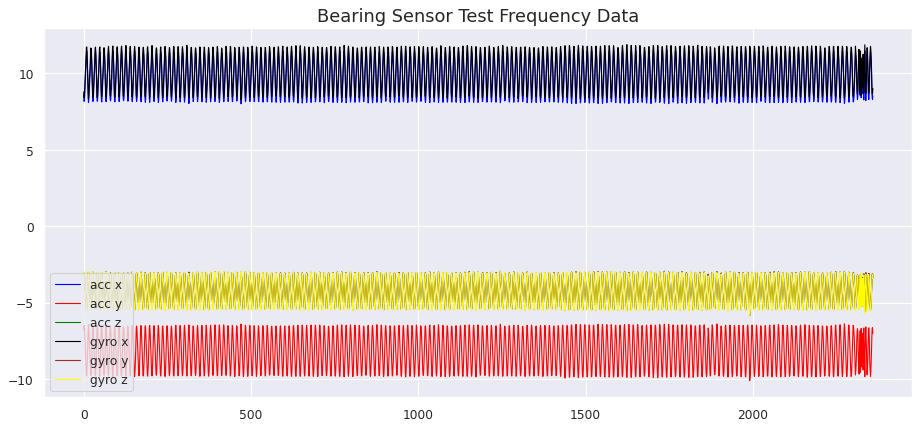

In [ ]:
# frequencies of the degrading sensor signal
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(test_fft[:,0].real, label='acc x', color='blue', animated = True, linewidth=1)
ax.plot(test_fft[:,1].imag, label='acc y', color='red', animated = True, linewidth=1)
ax.plot(test_fft[:,2].real, label='acc z', color='green', animated = True, linewidth=1)
ax.plot(test_fft[:,3].real, label='gyro x', color='black', animated = True, linewidth=1)
ax.plot(test_fft[:,4].real, label='gyro y', color='brown', animated = True, linewidth=1)
ax.plot(test_fft[:,5].real, label='gyro z', color='yellow', animated = True, linewidth=1)
plt.legend(loc='lower left')
ax.set_title('Bearing Sensor Test Frequency Data', fontsize=16)
plt.show()

In [ ]:
# Import the MinMaxScaler class from the preprocessing module of the scikit-learn library
scaler = MinMaxScaler()

# Use the fit_transform() method of the scaler object to normalize the training data
# This scales each feature to a range between 0 and 1
X_train = scaler.fit_transform(train)

# Use the transform() method of the scaler object to normalize the test data
# Note that we only use transform() here, not fit_transform()
# This ensures that we use the same scaling as we did on the training data
X_test = scaler.transform(test)

# Save the scaler object to a file for later use
scaler_filename = "scaler_data"
joblib.dump(scaler, scaler_filename)


['scaler_data']

In [ ]:
# Reshape the training data to have three dimensions [samples, timesteps, features]
# This is necessary for input into an LSTM model
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])

# Print the new shape of the training data to verify that it has been reshaped correctly
print("Training data shape:", X_train.shape)

# Reshape the test data to have three dimensions [samples, timesteps, features]
# This is necessary for input into an LSTM model
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

# Print the new shape of the test data to verify that it has been reshaped correctly
print("Test data shape:", X_test.shape)


Training data shape: (9433, 1, 6)
Test data shape: (2359, 1, 6)


In [ ]:
# Define a function named autoencoder_model that takes an input tensor X as argument
def autoencoder_model(X):
    
    # Define an input layer with shape (number of timesteps, number of features)
    inputs = Input(shape=(X.shape[1], X.shape[2]))
    
    # Define an LSTM layer with 16 units, relu activation function, and L2 regularization
    # This layer returns sequences, so return_sequences=True
    L1 = LSTM(16, activation='relu', return_sequences=True, 
              kernel_regularizer=regularizers.l2(0.00))(inputs)
    
    # Define another LSTM layer with 6 units, relu activation function, and no regularization
    # This layer does not return sequences, so return_sequences=False
    L2 = LSTM(6, activation='relu', return_sequences=False)(L1)
    
    # Define a RepeatVector layer that repeats the input for each timestep (i.e. sequence length)
    # The input to this layer is the output of the previous LSTM layer (L2)
    # The number of timesteps is taken from the shape of the input tensor (X)
    L3 = RepeatVector(X.shape[1])(L2)
    
    # Define another LSTM layer with 6 units, relu activation function, and no regularization
    # This layer returns sequences, so return_sequences=True
    L4 = LSTM(6, activation='relu', return_sequences=True)(L3)
    
    # Define another LSTM layer with 16 units, relu activation function, and no regularization
    # This layer returns sequences, so return_sequences=True
    L5 = LSTM(16, activation='relu', return_sequences=True)(L4)
    
    # Define a TimeDistributed Dense layer with the same number of features as the input
    # This layer applies the same dense layer to each timestep in the sequence
    output = TimeDistributed(Dense(X.shape[2]))(L5)
    
    # Create a Keras model with the input layer and output layer
    model = Model(inputs=inputs, outputs=output)
    
    # Return the model
    return model


In [ ]:
# Call the autoencoder_model function to create a new autoencoder model
model = autoencoder_model(X_train)

# Compile the model with the Adam optimizer and mean absolute error (MAE) loss function
model.compile(optimizer='adam', loss='mae')

# Print a summary of the model's architecture, including the layers, output shape, and number of parameters
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1, 6)]            0         
                                                                 
 lstm (LSTM)                 (None, 1, 16)             1472      
                                                                 
 lstm_1 (LSTM)               (None, 6)                 552       
                                                                 
 repeat_vector (RepeatVector  (None, 1, 6)             0         
 )                                                               
                                                                 
 lstm_2 (LSTM)               (None, 1, 6)              312       
                                                                 
 lstm_3 (LSTM)               (None, 1, 16)             1472      
                                                             

In [ ]:
# Set the number of epochs and batch size for training
nb_epochs = 30
batch_size = 10

# Fit the autoencoder model to the training data
# The model is trained to predict the same input sequence as the output sequence (i.e., X_train)
# validation_split=0.05 means that 5% of the training data is used for validation
history = model.fit(X_train, X_train, epochs=nb_epochs, batch_size=batch_size,
                    validation_split=0.05).history


Epoch 1/30
897/897 [==============================] - 28s 19ms/step - loss: 0.1318 - val_loss: 0.0800
Epoch 2/30
897/897 [==============================] - 15s 17ms/step - loss: 0.0811 - val_loss: 0.0780
Epoch 3/30
897/897 [==============================] - 18s 20ms/step - loss: 0.0803 - val_loss: 0.0779
Epoch 4/30
897/897 [==============================] - 15s 16ms/step - loss: 0.0790 - val_loss: 0.0647
Epoch 5/30
897/897 [==============================] - 15s 17ms/step - loss: 0.0312 - val_loss: 0.0203
Epoch 6/30
897/897 [==============================] - 21s 24ms/step - loss: 0.0212 - val_loss: 0.0183
Epoch 7/30
897/897 [==============================] - 19s 21ms/step - loss: 0.0195 - val_loss: 0.0162
Epoch 8/30
897/897 [==============================] - 16s 17ms/step - loss: 0.0181 - val_loss: 0.0155
Epoch 9/30
897/897 [==============================] - 15s 17ms/step - loss: 0.0177 - val_loss: 0.0165
Epoch 10/30
897/897 [==============================] - 16s 18ms/step - loss: 0.017

In [ ]:
# save the model to a specific path
model.save('/content/drive/MyDrive/Machine_learning/PROJECTS/anomaly_detection/anomaly_detection.h5')


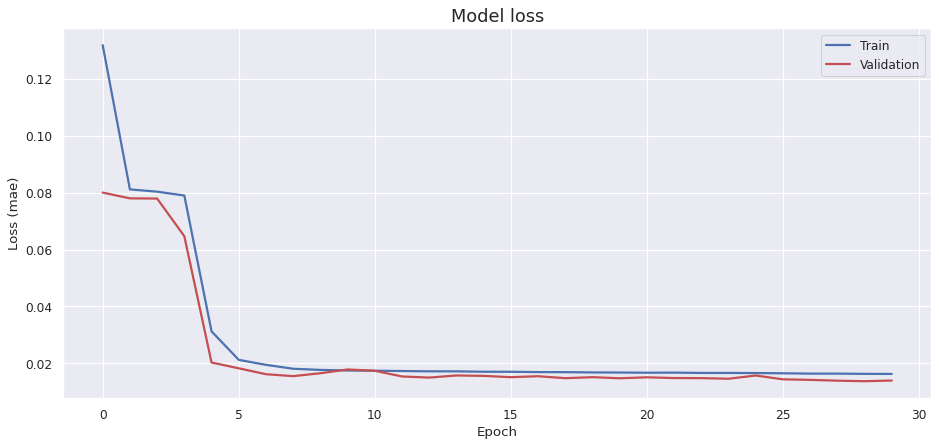

In [ ]:
# Create a new figure with a size of 14x6 inches and a resolution of 80 dots per inch (dpi)
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)

# Plot the training loss as a blue line and the validation loss as a red line
ax.plot(history['loss'], 'b', label='Train', linewidth=2)
ax.plot(history['val_loss'], 'r', label='Validation', linewidth=2)

# Set the title, y-axis label, and x-axis label of the plot
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')

# Add a legend to the plot to distinguish the training and validation lines
ax.legend(loc='upper right')

# Display the plot
plt.show()


295/295 [==============================] - 1s 2ms/step


<ipython-input-24-370c42456156>:27: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(scored['Loss_mae'], bins=20, kde=True, color='blue')


(0.0, 0.5)

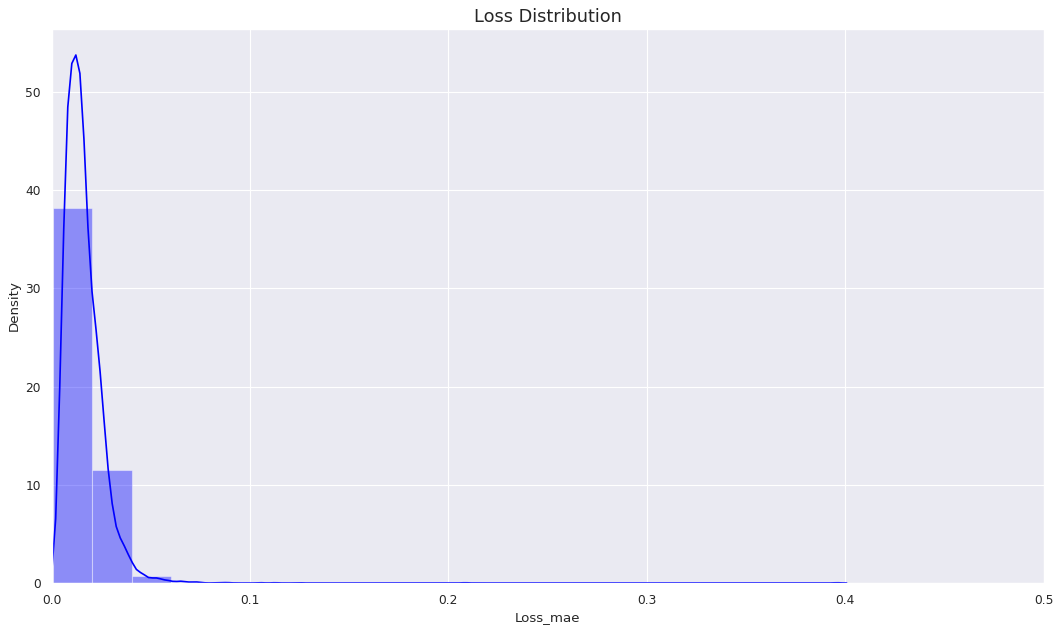

In [ ]:
# Use the trained autoencoder to predict the reconstruction of the training data
X_pred = model.predict(X_train)

# Reshape the predicted data to have the same number of samples as the original data
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])

# Convert the predicted data to a Pandas DataFrame with the original column names and index
X_pred = pd.DataFrame(X_pred, columns=train.columns)
X_pred.index = train.index

# Create an empty DataFrame to store the loss values for each sample in the training set
scored = pd.DataFrame(index=train.index)

# Reshape the training data to a 2D array to calculate the mean absolute error (MAE) loss
Xtrain = X_train.reshape(X_train.shape[0], X_train.shape[2])

# Calculate the MAE loss for each sample in the training set and store the results in the 'Loss_mae' column of 'scored'
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtrain), axis=1)

# Create a new figure with a size of 16x9 inches and a resolution of 80 dots per inch (dpi)
plt.figure(figsize=(16, 9), dpi=80)

# Set the title of the plot
plt.title('Loss Distribution', fontsize=16)

# Plot a histogram of the MAE loss values with 20 bins and a blue color
sns.distplot(scored['Loss_mae'], bins=20, kde=True, color='blue')

# Set the x-axis limit to be between 0 and 0.5
plt.xlim([0.0, 0.5])


In [ ]:
# calculate the loss on the test set
X_pred = model.predict(X_test)  # make predictions on the test set
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])  # reshape predictions
X_pred = pd.DataFrame(X_pred, columns=test.columns)  # create a DataFrame from predictions
X_pred.index = test.index  # set the index to match the test set

scored = pd.DataFrame(index=test.index)  # create a DataFrame to hold the scores
Xtest = X_test.reshape(X_test.shape[0], X_test.shape[2])  # reshape the test set
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtest), axis=1)  # calculate the mean absolute error (MAE) loss
scored['Threshold'] = 0.4  # set a threshold value
scored['Anomaly'] = scored['Loss_mae'] > scored['Threshold']  # flag any anomalies above the threshold
scored.head()  # show the first few rows of the scored DataFrame


74/74 [==============================] - 1s 6ms/step


,Loss_mae,Threshold,Anomaly
9433,0.010814,0.4,False
9434,0.010333,0.4,False
9435,0.006737,0.4,False
9436,0.009635,0.4,False
9437,0.012326,0.4,False


In [ ]:
# Use the trained model to make predictions on the training set
X_pred_train = model.predict(X_train)

# Reshape the predicted data to have the same number of rows and columns as the training set
X_pred_train = X_pred_train.reshape(X_pred_train.shape[0], X_pred_train.shape[2])

# Convert the predicted data to a pandas dataframe with column names matching the training set
X_pred_train = pd.DataFrame(X_pred_train, columns=train.columns)

# Set the index of the predicted data to match the index of the training set
X_pred_train.index = train.index

# Create an empty pandas dataframe with the same index as the training set to hold the results of the anomaly detection
scored_train = pd.DataFrame(index=train.index)

# Calculate the mean absolute error (MAE) between the predicted and actual values for each row in the training set
scored_train['Loss_mae'] = np.mean(np.abs(X_pred_train-Xtrain), axis = 1)

# Set a fixed threshold for determining whether a row is an anomaly or not
scored_train['Threshold'] = 0.4

# Determine whether each row in the training set is an anomaly based on whether its MAE is above the threshold
scored_train['Anomaly'] = scored_train['Loss_mae'] > scored_train['Threshold']

# Concatenate the results of the anomaly detection on the training set with the results of the anomaly detection on the test set
scored = pd.concat([scored_train, scored])


295/295 [==============================] - 1s 5ms/step


<Axes: >

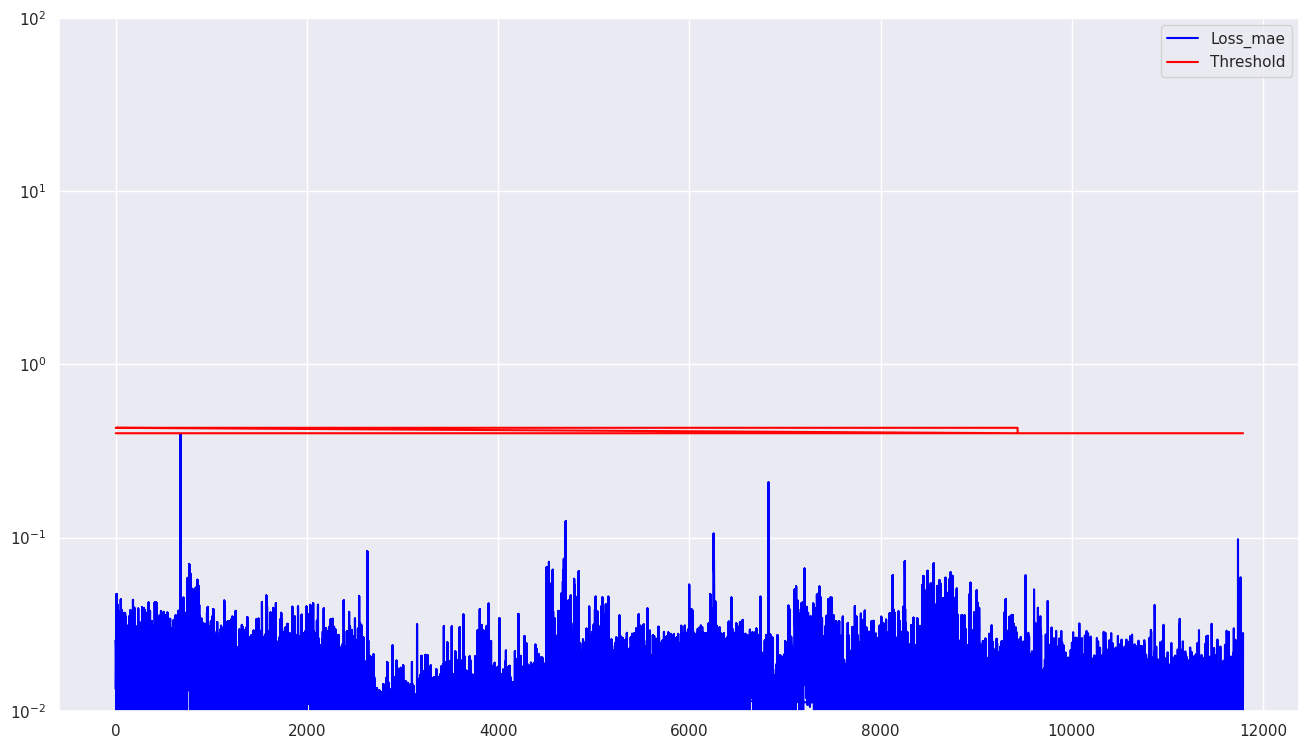

In [ ]:
# plot motor failure time plot
scored.plot(logy=True,  figsize=(16,9), ylim=[1e-2,1e2], color=['blue','red'])